<a href="https://colab.research.google.com/github/aquapathos/weatherforecast/blob/main/%E3%82%A2%E3%83%A1%E3%83%80%E3%82%B9%E6%83%85%E5%A0%B1%E3%81%AB%E3%82%88%E3%82%8B%E6%B2%B3%E5%B7%9D%E6%B0%B4%E4%BD%8D%E3%81%AE%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 観測所データのダウンロード

In [ ]:
# 観測所データをダウンロード
import urllib.request,os
url = "https://raw.githubusercontent.com/aquapathos/weatherforecast/refs/heads/main/stationscraper.py"
urllib.request.urlretrieve(url,'stationscrapper.py')
from stationscrapper import AmedasStationScraper
file_path = '観測所データ.csv'
if os.path.isfile(file_path):
    scrapper = AmedasStationScraper(file_path = file_path)
else:
    scrapper = AmedasStationScraper(file_path = None)
    scrapper.stations.to_csv(file_path, index=False, encoding='utf-8-sig')
scrapper.stations # 表示

,地域,観測所,prec_no,block_no,type,観測所カナ,緯度,経度,標高
0,宗谷地方,稚内,11,47401,s,ワツカナイ,45.415,141.67833333333334,2.8
1,宗谷地方,沓形,11,0002,a,クツガタ,45.178333333333335,141.13833333333332,14.0
2,宗谷地方,浜頓別,11,0003,a,ハマトンベツ,45.125,142.35,18.0
3,宗谷地方,北見枝幸,11,47402,s,キタミエサシ,44.94,142.585,6.7
4,宗谷地方,歌登,11,0005,a,ウタノボリ,44.84166666666667,142.48,14.0
...,...,...,...,...,...,...,...,...,...
1672,沖縄県,国頭,91,1586,a,クニガミ,26.72833333333333,128.17833333333334,8.0
1673,沖縄県,宮城島,91,1596,a,ミヤギジマ,26.363333333333333,127.97166666666666,100.0
1674,沖縄県,盛山,91,1639,a,モリヤマ,24.395,124.245,31.0
1675,沖縄県,渡名喜,91,1651,a,トナキ,26.373333333333335,127.14166666666667,7.0


## アメダスデータのダウンロード

In [ ]:
# アメダスデータのダウンロード
from tqdm.notebook import tqdm
import requests
from bs4 import BeautifulSoup
import csv

# stations = {"大阪":[62,47772], "広島":[67,47765]}
stations = ["河内長野","堺","大阪"]

# データがないときは０
def str2float(str):
  try:
    return float(str)
  except:
    return 0.0
# リスト stations に挙げた観測所それぞれについてデータを取得
for station in stations:
  prec_no, block_no, station_type = scrapper.getID(station) # stations[station]
  print(station, prec_no, block_no, station_type)
  #最終的にデータを集めるリスト
  if station_type == "s": # 測候所
      All_list = [['年月日', '観測地点','prec_no','block_no','現地平均気圧(hPa)', '海面平均気圧(hPa)', '降水量(mm)', '平均気温(℃)', '平均湿度(%)', '平均風速(m/s)', '日照時間(h)']]
      base_url = "https://www.data.jma.go.jp/obd/stats/etrn/view/daily_s1.php?prec_no=%s&block_no=%s&year=%s&month=%s&day=1&view="
  else:  # アメダス
      All_list = [['年月日', '観測地点','prec_no','block_no','降水量(mm)', '平均気温(℃)', '平均湿度(%)', '平均風速(m/s)', '日照時間(h)']]
      base_url = "https://www.data.jma.go.jp/obd/stats/etrn/view/daily_a1.php?prec_no=%s&block_no=%s&year=%s&month=%s&day=1&view="
  # 2022年から2024年までのデータを取得
  for year in tqdm(range(2022,2025)):
    for month in range(1,13):
      # base_urlに地域番号、地点番号、年、月をあてはめてリクエスト
      html = requests.get(base_url%(prec_no, block_no, year, month))
      html.encoding = html.apparent_encoding
      # まずはサイトごとスクレイピング
      soup = BeautifulSoup(html.text)
      rows = soup.findAll('tr',class_='mtx')
      # 表の最初の3行はないし4行はカラム情報なのでカット
      if station_type == "s": # 測候所
          rows = rows[4:]
      else:  # アメダス
          rows = rows[3:]
      # 1日〜最終日までの１行を網羅し、取得します。
      for row in rows:
        # trのなかのtdをすべて抜き出す
        data = row.findAll('td')
        # データを切り分け
        rowData = [str(year) + "/" + str(month) + "/" + str(data[0].string),station, prec_no, block_no]
        extract = [1,2,3,6,9,11,16] if station_type == "s" else [1,4,7,9,15]
        for i in extract:
          rowData.append(str2float(data[i].string))
        All_list.append(rowData)

  #都市ごとにデータをファイルを新しく生成して書き出す。(csvファイル形式。名前は都市名)
  with open(station + '.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerows(All_list)

# 河川水位情報のダウンロード


In [ ]:
# Playwright のインストール
!pip -qq install playwright
!playwright install-deps > /dev/null 2>&1
!playwright install > /dev/null 2>&1
!playwright install webkit > /dev/null 2>&1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 20.5 MB/s eta 0:00:00


In [ ]:
# 河川水位データのダウンロード
import asyncio
from playwright.async_api import async_playwright
import pandas as pd
from pathlib import Path
import zipfile

# 2022年8月から2024年12月までのデータを取得　（大阪府の災害情報の過去データは2022年８月以降しか公開されていない）
async def main(area="泉州",year_start=2022,month_start=8,year_end=2024,month_end=12):
    async with async_playwright() as p:
        browser = await p.webkit.launch(headless=True)
        page = await browser.new_page()
        await page.goto("https://www.osaka-kasen-portal.net/suibou/public/ja/historydata.html")
        await page.locator("#data_sbt").select_option("1") # 水位
        await page.locator("#data_chiki").select_option(area)
        year_start = year_start
        month_start = month_start
        year_end = year_end
        month_end = month_end

        df = pd.DataFrame()

        for year in range(year_start,year_end+1):
            mostart = month_start if year == year_start else 1
            moend = month_end if year == year_end else 12
            for month in range(mostart,moend+1):
                print(f"{year}年{month}月")
                await page.locator("#daterange-radio1").check()
                await page.locator(".input-group-append").click()
                await page.locator(".ui-datepickerMonth-year").select_option(str(year))
                await page.locator('.ui-datepickerMonth-calendar').locator('tr').nth((month-1)//4+1).locator('td').nth((month-1)%4).click()

                # ダウンロード
                async with page.expect_download(timeout=30000) as download_info: # Increased timeout to 60 seconds
                    await page.locator("#download").click()
                    # Handle the download event within expect_download
                    download = await download_info.value
                    zip_file = Path.cwd() / download.suggested_filename
                    await download.save_as(zip_file)

                    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                        zip_ref.extractall()
                    os.rename(zip_ref.namelist()[0],os.path.splitext(zip_file)[0]+".csv") # csvファイルの文字化けを修正
                    os.remove(os.path.splitext(zip_file)[0]+".zip")

                    df1 = pd.read_csv(os.path.splitext(zip_file)[0]+".csv", encoding='shift-jis',header=[0,1],skiprows=[2,3])

                    df = pd.concat([df,df1], ignore_index=True)

        await browser.close()
        # 日時欄を日と時刻に分割する
        df['観測所', '日'] = pd.to_datetime(df['所管', '観測所']).dt.date
        df['観測所', '時刻'] = pd.to_datetime(df['所管', '観測所']).dt.time
        df = df.drop(columns=[('所管', '観測所')])
        # 日時カラムを先頭に移動
        cols = df.columns.tolist()
        cols = [cols[-2]] + [cols[-1]] + cols[:-2]
        df = df[cols]
        return df # .replace('***', float('nan'), inplace=False) # Use inplace=False

df = await main("泉州",2022,8,2024,12)
# df.to_excel('泉州水位.xlsx', sheet_name=f'泉州の水位')

In [ ]:
df.head()

# 日ごとの最大水位データの生成


In [ ]:
# データフレーム df において、（所管、観測所）の日ごとの最大水位のデータを生成
def maxwater(df = None, kansokusho='戎橋',shokan = None, savefile=False):
    if shokan == None:
       for col1, col2 in df.columns:
          if col2 == kansokusho:
             shokan = col1
             break
    df.loc[df[(shokan,kansokusho)]=='***'] = float('nan') # 欠損データを nan に置き換え
    df[(shokan,kansokusho)] = df[(shokan,kansokusho)].astype(float) # 文字データになっているので数値化
    daylymax_df = df[[('観測所','日'),(shokan,kansokusho)]].groupby(('観測所', '日')).max().reset_index() # 日ごとに最大値を抽出
    # daylymax_df['観測所', '日'] = pd.to_datetime(daylymax_df['観測所', '日']).dt.strftime('%Y/%m/%d')
    # カラムを1行にまとめ、"年月日","水位"に変える
    daylymax_df.columns = ["年月日","水位"]
    if savefile:
        daylymax_df.to_csv(f'{kansokusho}.csv',index=False)
    return daylymax_df

daymax_df = maxwater(df,'戎橋',savefile = True)
daymax_df

,年月日,水位
0,2022-08-01,2.08
1,2022-08-02,2.02
2,2022-08-03,2.00
3,2022-08-04,2.02
4,2022-08-05,2.07
...,...,...
866,2024-12-14,2.06
867,2024-12-15,2.14
868,2024-12-16,2.13
869,2024-12-17,2.03


## 日毎の水位のグラフ化

In [ ]:
# 日本語matplotlibのインストール
!pip -qq install japanize-matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 54.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


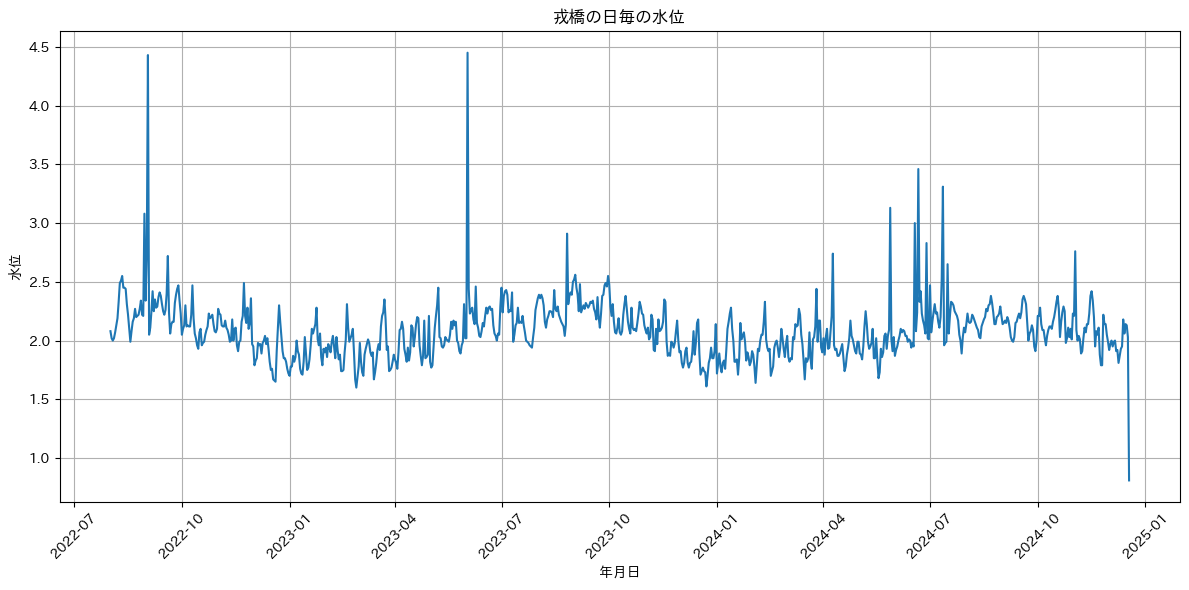

In [ ]:
# 水位のグラフ化

dates = daymax_df['年月日']
water_levels = daymax_df['水位']

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(dates, water_levels)

# Customize the plot (optional)
plt.xlabel('年月日')
plt.ylabel('水位')
plt.title('戎橋の日毎の水位')
plt.grid(True)
plt.xticks(rotation=45)  # X軸ラベルを45度回転させる
plt.tight_layout()      # ラベルが重ならないようにレイアウトを調整

# Show the plot
plt.show()

In [ ]:
# 降雨データと戎橋の水位データを統合する
def integrate(amedass = ['堺'], waterlebels = '戎橋'):
  waterlebelCSV = f'{waterlebels}.csv'
  lebel_df = pd.read_csv(waterlebelCSV)
  lebel_df['年月日'] = pd.to_datetime(lebel_df['年月日'])

  merge_df = lebel_df
  for amedas in amedass:
    amedasCSV = f'{amedas}.csv'
    amedas_df = pd.read_csv(amedasCSV)
    amedas_df['年月日'] = pd.to_datetime(amedas_df['年月日'])
    amedas_df = amedas_df[['年月日'] + amedas_df.columns[4:].tolist()]
    amedas_df = amedas_df[amedas_df['年月日']>='2022-08-01']
    # 年月日を基準に２つのデータを統合
    merge_df = pd.merge(amedas_df, merge_df, on = '年月日')
  return merge_df

In [ ]:
# 例として堺のアメダスデータと戎橋の水位データを統合
sakaiEbisu_df = integrate(['堺'],'戎橋')
sakaiEbisu_df

,年月日,降水量(mm),平均気温(℃),平均湿度(%),平均風速(m/s),日照時間(h),水位
0,2022-08-01,0.0,31.0,68.0,1.8,13.1,2.08
1,2022-08-02,0.0,30.5,70.0,1.4,12.1,2.02
2,2022-08-03,0.0,30.9,71.0,1.6,10.6,2.00
3,2022-08-04,0.0,30.3,77.0,1.9,7.1,2.02
4,2022-08-05,0.0,29.1,78.0,1.4,5.0,2.07
...,...,...,...,...,...,...,...
866,2024-12-14,0.0,7.1,62.0,2.1,0.5,2.06
867,2024-12-15,0.0,7.9,56.0,3.2,2.7,2.14
868,2024-12-16,0.0,8.8,54.0,2.3,0.8,2.13
869,2024-12-17,0.0,8.6,55.0,2.5,7.4,2.03


In [ ]:
kawachiEbisu_df = integrate(['河内長野'],'戎橋')
kawachiEbisu_df

,年月日,降水量(mm),平均気温(℃),平均湿度(%),平均風速(m/s),日照時間(h),水位
0,2022-08-01,0.0,0.0,0.0,0.0,0.0,2.08
1,2022-08-02,0.0,0.0,0.0,0.0,0.0,2.02
2,2022-08-03,0.0,0.0,0.0,0.0,0.0,2.00
3,2022-08-04,0.0,0.0,0.0,0.0,0.0,2.02
4,2022-08-05,0.0,0.0,0.0,0.0,0.0,2.07
...,...,...,...,...,...,...,...
866,2024-12-14,2.0,0.0,0.0,0.0,0.0,2.06
867,2024-12-15,0.0,0.0,0.0,0.0,0.0,2.14
868,2024-12-16,0.0,0.0,0.0,0.0,0.0,2.13
869,2024-12-17,0.0,0.0,0.0,0.0,0.0,2.03


In [ ]:
# 河内長野，堺，大阪の降雨データと戎橋の水位データを統合する
merge3_df = integrate(['河内長野','堺','大阪'],'戎橋')
merge3_df

,年月日,現地平均気圧(hPa),海面平均気圧(hPa),降水量(mm),平均気温(℃),平均湿度(%),平均風速(m/s),日照時間(h),降水量(mm)_x,平均気温(℃)_x,平均湿度(%)_x,平均風速(m/s)_x,日照時間(h)_x,降水量(mm)_y,平均気温(℃)_y,平均湿度(%)_y,平均風速(m/s)_y,日照時間(h)_y,水位
0,2022-08-01,1004.2,1013.5,0.0,31.1,63.0,2.7,13.2,0.0,31.0,68.0,1.8,13.1,0.0,0.0,0.0,0.0,0.0,2.08
1,2022-08-02,1004.5,1013.8,0.0,30.9,64.0,2.4,12.6,0.0,30.5,70.0,1.4,12.1,0.0,0.0,0.0,0.0,0.0,2.02
2,2022-08-03,1002.1,1011.4,3.5,31.0,67.0,2.5,10.5,0.0,30.9,71.0,1.6,10.6,0.0,0.0,0.0,0.0,0.0,2.00
3,2022-08-04,999.4,1008.7,2.5,29.9,72.0,2.8,5.7,0.0,30.3,77.0,1.9,7.1,0.0,0.0,0.0,0.0,0.0,2.02
4,2022-08-05,997.7,1007.0,1.5,28.5,78.0,1.7,3.9,0.0,29.1,78.0,1.4,5.0,0.0,0.0,0.0,0.0,0.0,2.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,2024-12-14,1006.3,1016.5,0.0,6.9,63.0,2.5,0.9,0.0,7.1,62.0,2.1,0.5,2.0,0.0,0.0,0.0,0.0,2.06
867,2024-12-15,1007.8,1017.9,0.0,7.9,55.0,3.3,7.6,0.0,7.9,56.0,3.2,2.7,0.0,0.0,0.0,0.0,0.0,2.14
868,2024-12-16,1008.5,1018.7,0.0,8.6,55.0,2.4,5.4,0.0,8.8,54.0,2.3,0.8,0.0,0.0,0.0,0.0,0.0,2.13
869,2024-12-17,1010.4,1020.6,0.0,8.6,54.0,2.7,7.6,0.0,8.6,55.0,2.5,7.4,0.0,0.0,0.0,0.0,0.0,2.03


# 重回帰

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# ７日間のアメダスデータを入力、次の日の水位データを出力して重回帰する 説明変数には水位が含まれないことに注意
span = 7
merge_df = integrate(['堺'],'戎橋')
numpy_data = merge_df.to_numpy() # データフレームをnumpy arrayに変換
dataXwoSuii = numpy_data[:,1:-1] # 説明変数　水位以外
dataY = numpy_data[:,-1].reshape(-1,1) # 目的変数 水位
scalerXwoSuii = StandardScaler() # 説明変数の標準化器の準備
scalerXwoSuii.fit(dataXwoSuii) # 説明変数の平均と分散を計算
scalerY = StandardScaler() # 目的変数の標準化の準備
scalerY.fit(dataY) # 目的変数の平均と分散を計算
sdataXwoSuii = scalerXwoSuii.transform(dataXwoSuii) # 説明変数を標準化
sdataY = scalerY.transform(dataY) # 目的変数を標準化

XdatawoSuii = []
for i in range(len(merge_df)-span):
  data = sdataXwoSuii[i:i+span]  # １週間のデータを取り出す
  XdatawoSuii.append([d for d in data]) # Xdata にパッキング
ydata = sdataY[span:] #
XdatawoSuii = np.array(XdatawoSuii)
h,w,d = XdatawoSuii.shape
XdatawoSuii = XdatawoSuii.reshape((h,w*d))
ydata = np.array(ydata).reshape(-1,1)
XdatawoSuii.shape, ydata.shape
# ーーーーー
# ((864, 35), (864, 1))　　2024年12月18日時点

((864, 35), (864, 1))

In [ ]:
# データをすべて使って学習した場合
# 線形回帰モデルのインスタンスを作成
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model0 = LinearRegression()

# モデルを全データにフィットさせる
model0.fit(XdatawoSuii, ydata)

# 全データで予測を行う
y_predAll = model0.predict(XdatawoSuii)

# モデルの評価（平均二乗誤差）
mse = mean_squared_error(ydata, y_predAll)
print(f"平均二乗誤差: {mse}")

# ----
# 平均二乗誤差: 0.655527885907752

平均二乗誤差: 0.655527885907752


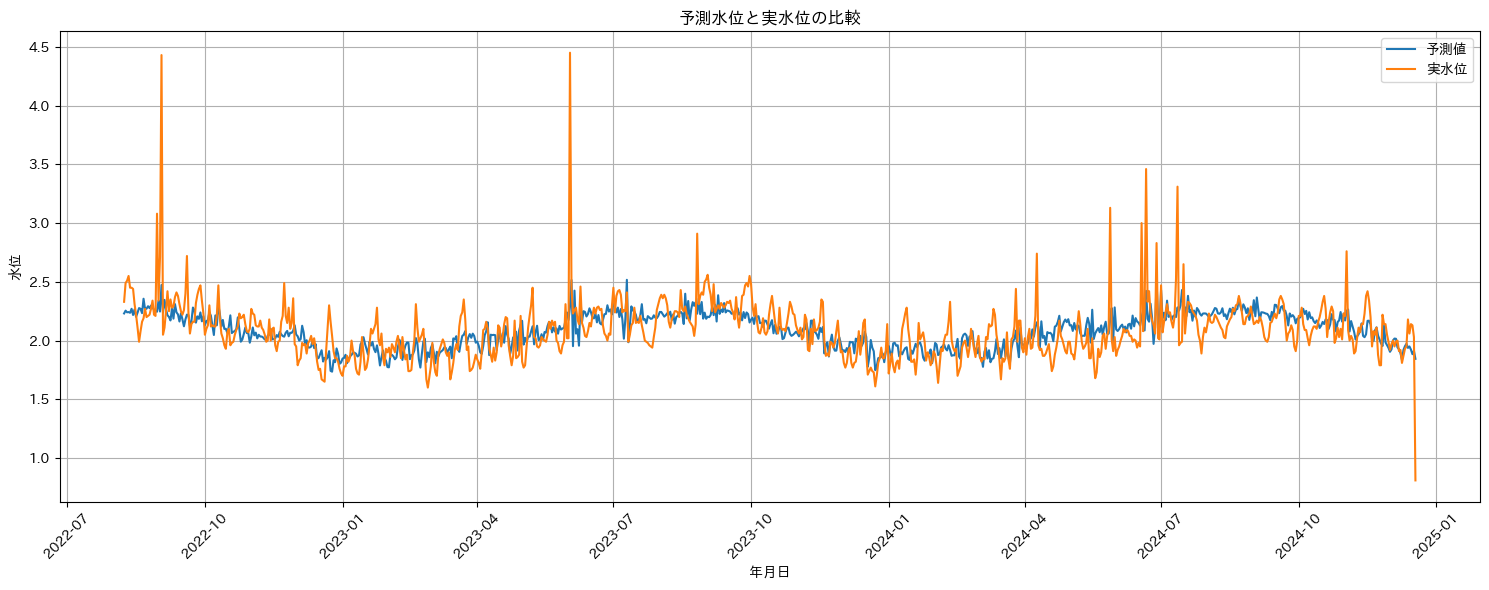

In [ ]:
# model0 で実水位と予測水位をプロット
def show0(models = [], frm = 0, to = -1):
    import matplotlib.pyplot as plt
    realdata = scalerY.inverse_transform(ydata[frm:to])

    dates = daymax_df['年月日'].to_numpy()[span+frm:span+to]

    plt.figure(figsize=(15, 6))  # Increase figure size

    if len(models) == 1:
        predictdata = scalerY.inverse_transform(models[0].predict(XdatawoSuii[frm:to]))
        plt.plot(dates,predictdata, label='予測値')
    else:
        for i,model in enumerate(models):
            predictdata = scalerY.inverse_transform(model.predict(XdatawoSuii[frm:to]))
            plt.plot(dates,predictdata, label=f'予測値{i+1}')

    plt.plot(dates,realdata, label='実水位')

    plt.xlabel('年月日')
    plt.ylabel('水位')
    plt.title('予測水位と実水位の比較')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    plt.show()

show0([model0],0,len(ydata))

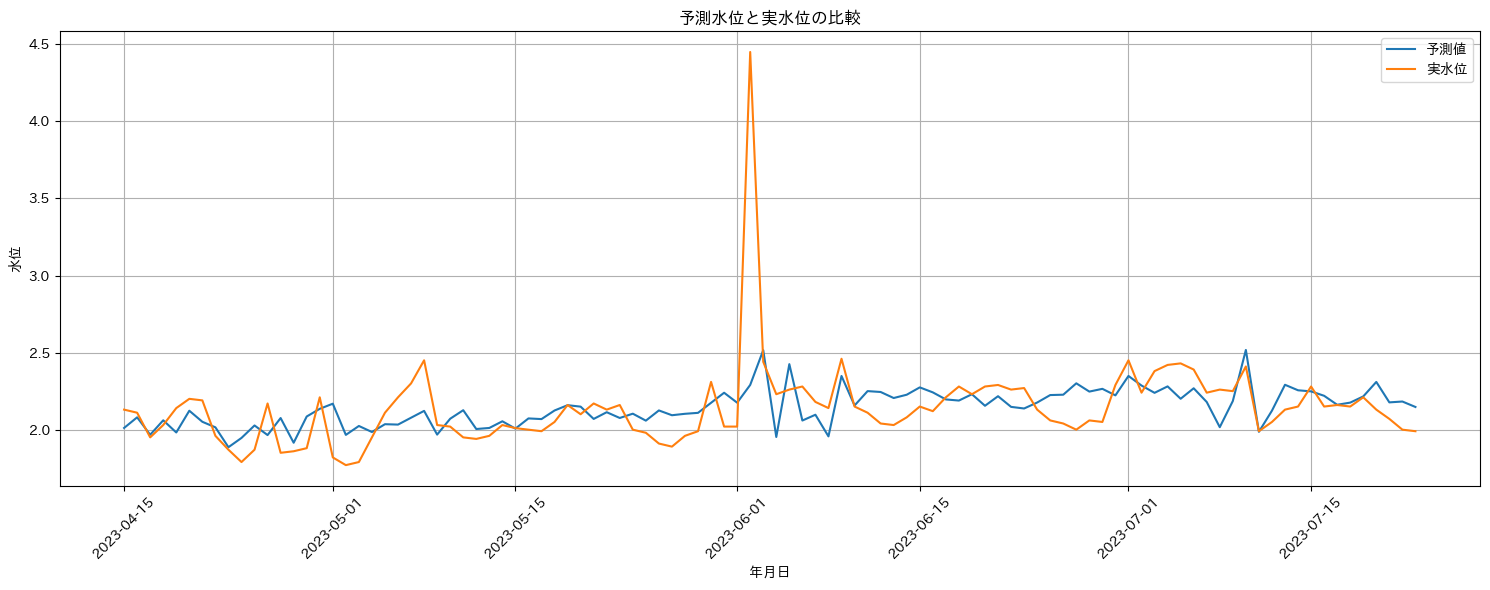

In [ ]:
# 部分拡大
show0([model0],250,350)

In [ ]:
# データを半分使って学習した場合
# 線形回帰モデルのインスタンスを作成

model01 = LinearRegression()
model02 = LinearRegression()

ndata = len(ydata)//2

# モデルを全データにフィットさせる
model01.fit(XdatawoSuii[:ndata], ydata[:ndata])
model02.fit(XdatawoSuii[ndata:], ydata[ndata:])

# 全データで予測を行う
y_predAll01 = model01.predict(XdatawoSuii)
y_predAll02 = model02.predict(XdatawoSuii)

# モデルの評価（平均二乗誤差）
mse01 = mean_squared_error(ydata, y_predAll01)
mse02 = mean_squared_error(ydata, y_predAll02)
print(f"前半データによる回帰の平均二乗誤差: {mse01}\n後半データによる回帰の平均二乗誤差: {mse02}")

# ----
前半データによる回帰の平均二乗誤差: 0.6837672340680773
後半データによる回帰の平均二乗誤差: 0.6957507480858091

前半データによる回帰の平均二乗誤差: 0.6841271603185417
後半データによる回帰の平均二乗誤差: 0.6982879882936084


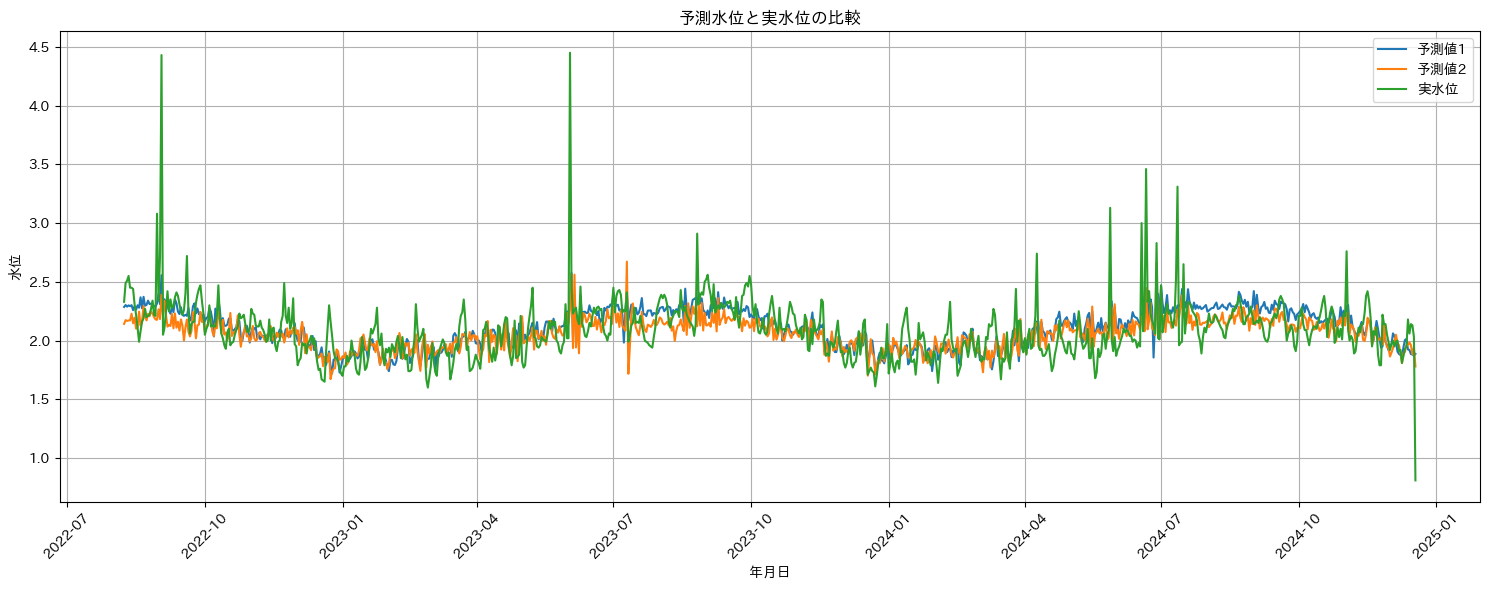

In [ ]:
show0([model01,model02],0,len(ydata))

In [ ]:
# ７日間のアメダスデータを入力、次の日の水位データを出力して重回帰する 説明変数に水位も含める
span = 7
# merge_df = integrate(['堺'],'戎橋')
# numpy_data = merge_df.to_numpy() # データフレームをnumpy arrayに変換
dataXwithSuii = numpy_data[:,1:] # 説明変数　日付以外　水位も含める
# dataY = numpy_data[:,-1].reshape(-1,1) # 目的変数 水位
scalerXwithSuii = StandardScaler() # 説明変数の標準化器の準備
scalerXwithSuii.fit(dataXwithSuii) # 説明変数の平均と分散を計算
# scalerY = StandardScaler() # 目的変数の標準化の準備
# scalerY.fit(dataY) # 目的変数の平均と分散を計算
sdataXwithSuii = scalerXwithSuii.transform(dataXwithSuii) # 説明変数を標準化
# sdataY = scalerY.transform(dataY) # 目的変数を標準化

XdatawithSuii = []
for i in range(len(merge_df)-span):
  data = sdataXwithSuii[i:i+span]  # １週間のデータを取り出す
  XdatawithSuii.append([d for d in data]) # Xdata にパッキング
# ydata = sdataY[span:] #
XdatawithSuii = np.array(XdatawithSuii)
h,w,d = XdatawithSuii.shape
XdatawithSuii = XdatawithSuii.reshape((h,w*d))
# ydata = np.array(ydata).reshape(-1,1)
XdatawithSuii.shape, ydata.shape
# ーーーーー
((862, 42), (862, 1))

((862, 42), (862, 1))

In [ ]:
# データをすべて使って学習した場合
# 線形回帰モデルのインスタンスを作成
model1 = LinearRegression()

# モデルを全データにフィットさせる
model1.fit(XdatawithSuii, ydata)

# 全データで予測を行う
y_predAll = model1.predict(XdatawithSuii)

# モデルの評価（平均二乗誤差）
mse = mean_squared_error(ydata, y_predAll)
print(f"平均二乗誤差: {mse}")

# ----
# 平均二乗誤差: 0.5365893502533342

平均二乗誤差: 0.5365893502533342


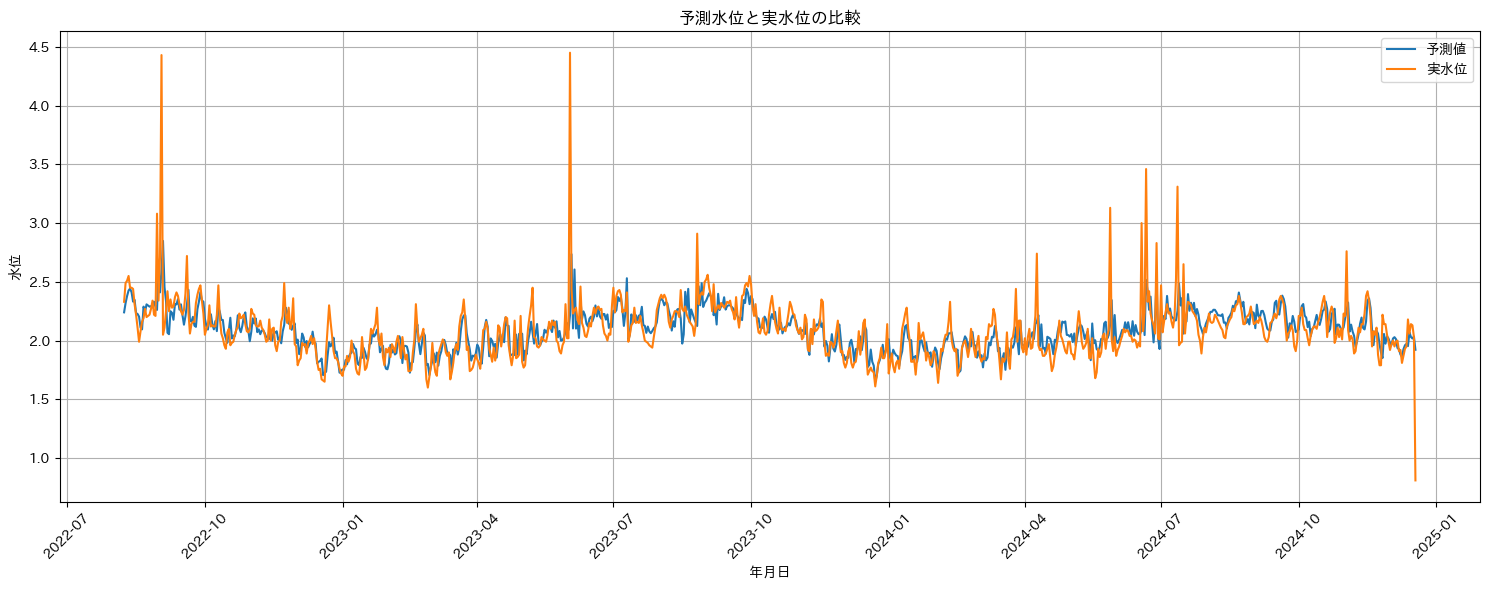

In [ ]:
# model1 で実水位と予測水位をプロット
def show1(models = [], frm = 0, to = -1):
    realdata = scalerY.inverse_transform(ydata[frm:to])

    dates = daymax_df['年月日'].to_numpy()[span+frm:span+to]

    plt.figure(figsize=(15, 6))

    if len(models) == 1:
        predictdata = scalerY.inverse_transform(models[0].predict(XdatawithSuii[frm:to]))
        plt.plot(dates,predictdata, label='予測値')
    else:
        for i,model in enumerate(models):
            predictdata = scalerY.inverse_transform(model.predict(XdatawithSuii[frm:to]))
            plt.plot(dates,predictdata, label=f'予測値{i+1}')

    plt.plot(dates,realdata, label='実水位')

    plt.xlabel('年月日')
    plt.ylabel('水位')
    plt.title('予測水位と実水位の比較')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    plt.show()

show1([model1],0,len(ydata))

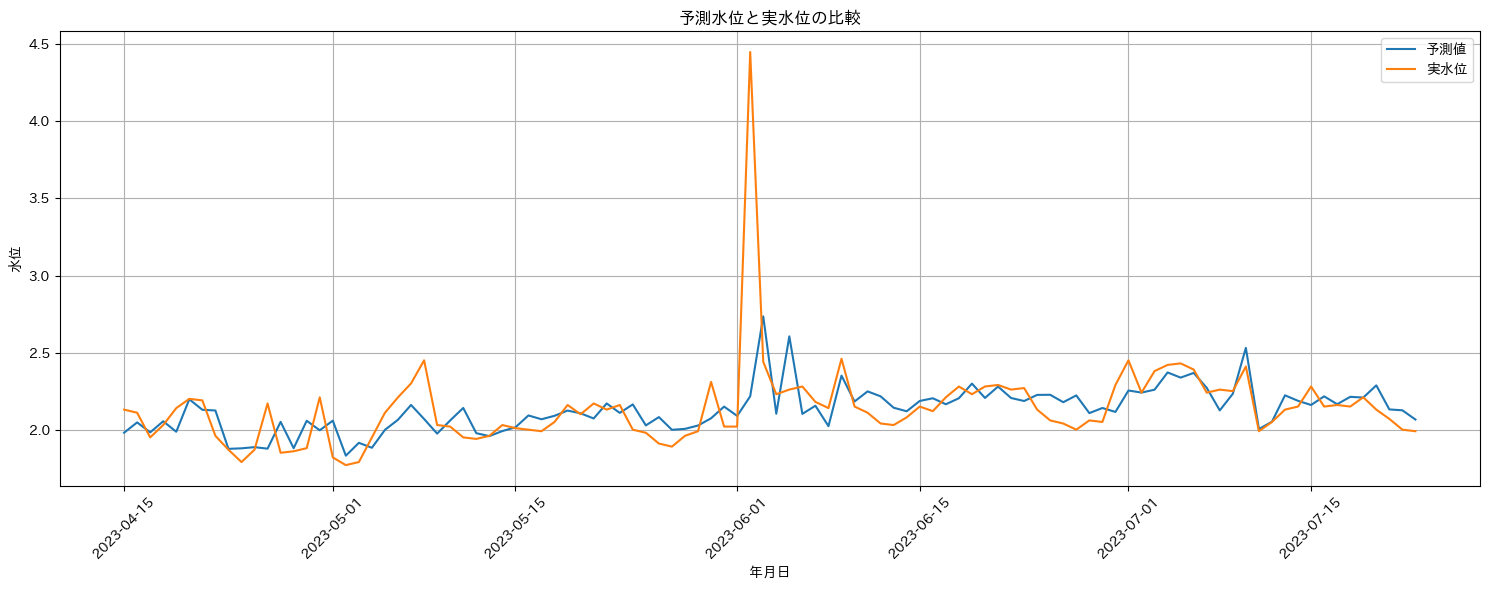

In [ ]:
show1([model1],250,350)

In [ ]:
# データを半分使って学習した場合
# 線形回帰モデルのインスタンスを作成

model11 = LinearRegression()
model12 = LinearRegression()

ndata = len(ydata)//2

# モデルを全データにフィットさせる
model11.fit(XdatawithSuii[:ndata], ydata[:ndata])
model12.fit(XdatawithSuii[ndata:], ydata[ndata:])

# 全データで予測を行う
y_predAll11 = model11.predict(XdatawithSuii)
y_predAll12 = model12.predict(XdatawithSuii)

# モデルの評価（平均二乗誤差）
mse11 = mean_squared_error(ydata, y_predAll11)
mse12 = mean_squared_error(ydata, y_predAll12)
print(f"前半データによる回帰の平均二乗誤差: {mse11}\n後半データによる回帰の平均二乗誤差: {mse12}")

# ----
前半データによる回帰の平均二乗誤差: 0.565148341618274
後半データによる回帰の平均二乗誤差: 0.5837603574719608

前半データによる回帰の平均二乗誤差: 0.565148341618274
後半データによる回帰の平均二乗誤差: 0.5837603574719608


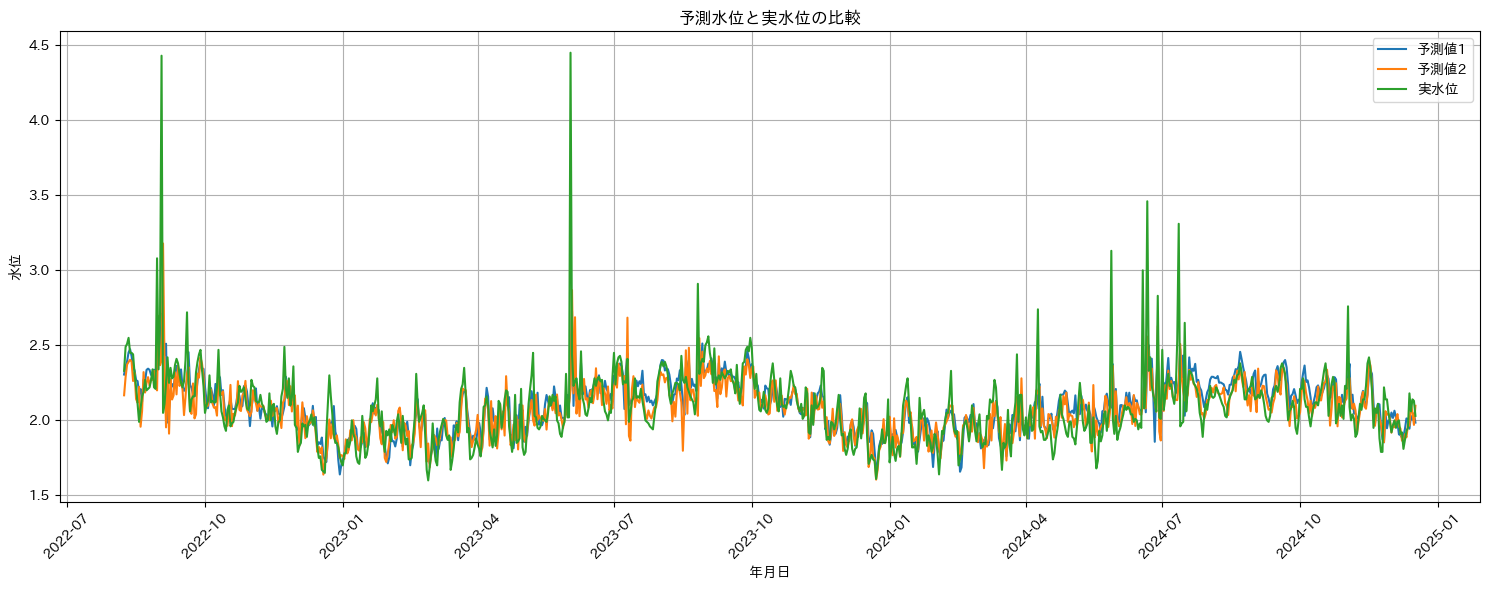

In [ ]:
show1([model11,model12],0,len(ydata)-1)

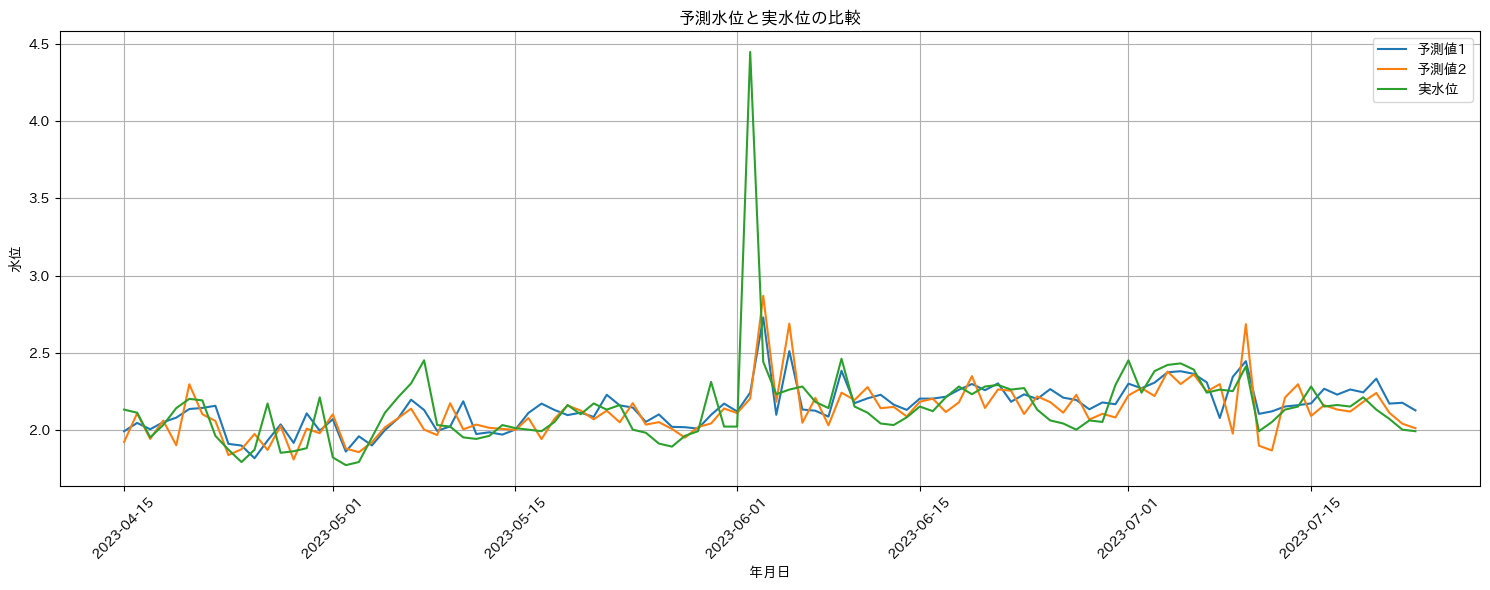

In [ ]:
show1([model11,model12],250,350)

# ニューラルネットワークを用いた予測

In [ ]:
import torch
import torch.utils.data

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms

#バッチサイズ
batch_size = 32

# 乱数のシードを固定して再現性を確保
torch.manual_seed(0);

# データセット，データローダの作成

In [ ]:
# 入力変数と目的変数をまとめて、ひとつのオブジェクト dataset に変換
X_tensor = torch.tensor(XdatawithSuii, dtype=torch.float32)
t_tensor = torch.tensor(ydata, dtype=torch.float32)

dataset = torch.utils.data.TensorDataset(X_tensor, t_tensor)
# データーローダを作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
# 単純な全結合４層ネットワーク　42→32→16→1
class Net0(nn.Module):

    # 使用するオブジェクトを定義
    def __init__(self):
        super(Net0, self).__init__()
        self.fc1 = nn.Linear(42, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    # 順伝播
    def forward(self, x):

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

# インスタンス化
model0 = Net0()

# 損失関数の設定(最小二乗誤差)
criterion0 = nn.MSELoss()

# 最適化手法の選択
optimizer0 = torch.optim.Adam(model0.parameters(), lr=0.01)

In [ ]:
# 全データを使った学習
def train_model0(net, dataloader, lossfun, optimizer, num_epoch, savefile = 'best_model.pth'):
    # GPUが使えるのであればGPUを有効化する
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    # (エポック)回分のループ
    for epoch in range(num_epoch):

        epoch_loss = 0.0

        for inputs, reallevel in tqdm(dataloader):
            # Move inputs and reallevel to the device
            inputs = inputs.to(device)
            reallevel = reallevel.to(device)
            reallavel = torch.reshape(reallevel,(-1,1)) #サイズ変更
            # 勾配を初期化する
            optimizer.zero_grad()

            # 学習モードの場合のみ勾配の計算を可能にする
            with torch.set_grad_enabled(True):
                # モデルの出力を計算
                outputs = net(inputs)
                outputs = outputs.to(device)

                # 損失を計算
                loss = lossfun(outputs, reallevel)
                # 誤差逆伝搬
                loss.backward()
                # パラメータ更新
                optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)

        # 1エポックでの損失を計算
        epoch_loss = epoch_loss / len(dataloader.dataset)

        #epoch数とlossを表示する
        print(f'Epoch {epoch + 1}/{num_epoch}  epoch_loss:{epoch_loss:.4f}')
        print('-'*20)

        #モデルを保存
        torch.save(net, savefile)
    return net

#学習と検証
num_epoch = 100
model0 = train_model0(model0, dataloader, criterion0, optimizer0, num_epoch)

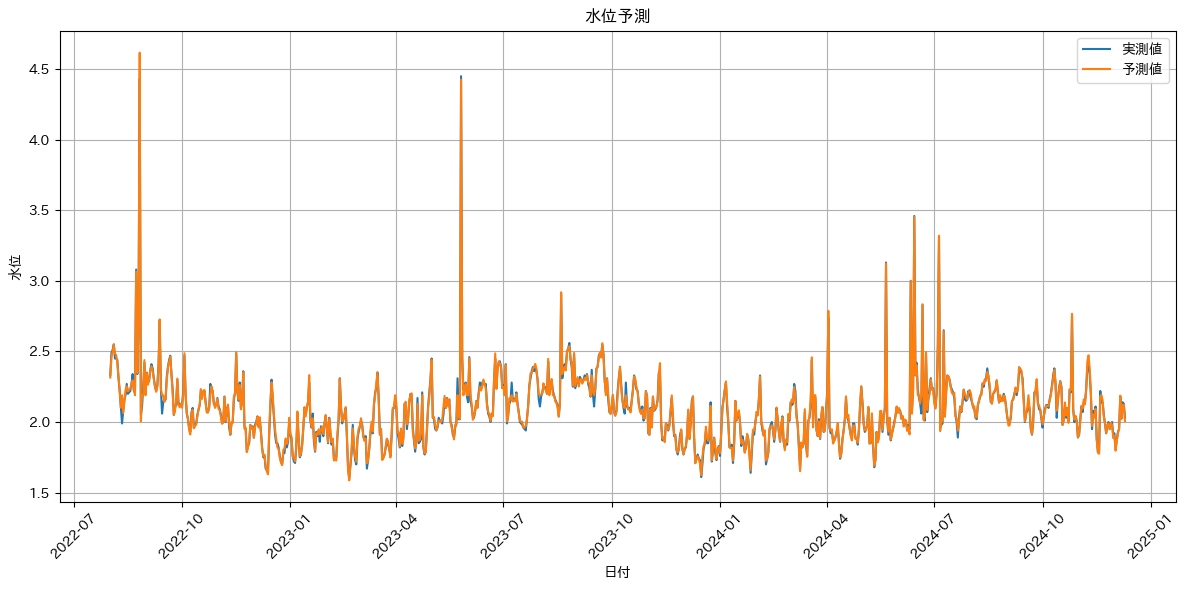

In [ ]:
# 上のプログラムで学習済みの net で全データの期間について水位予測し、実データと重ねてグラフを描く

def show0(net, frm,to): #, loadfile='best_model.pth'):

    # 学習済みデータを読み込む
    # net = torch.load(loadfile)

    # Use the entire dataset for prediction
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()

    # 全期間にわたって、説明変数ｘから水位を予測→ y_pred
    with torch.no_grad():
      y_pred = net(X_tensor.to(device))

    predicted_water_levels = y_pred.cpu().numpy().flatten()
    predicted_water_levels = scalerY.inverse_transform(predicted_water_levels.reshape(-1, 1))
    actual_water_levels = t_tensor.cpu().numpy()
    actual_water_levels = scalerY.inverse_transform(actual_water_levels.reshape(-1, 1))

    # Create date range for the plot
    date_range = pd.date_range(start=merge_df['年月日'].min(), periods=len(actual_water_levels))

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(date_range[frm:to], actual_water_levels[frm:to], label='実測値')
    plt.plot(date_range[frm:to], predicted_water_levels[frm:to], label='予測値')

    plt.xlabel('日付')
    plt.ylabel('水位')
    plt.title('水位予測')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

show0(model0, 0, -1)

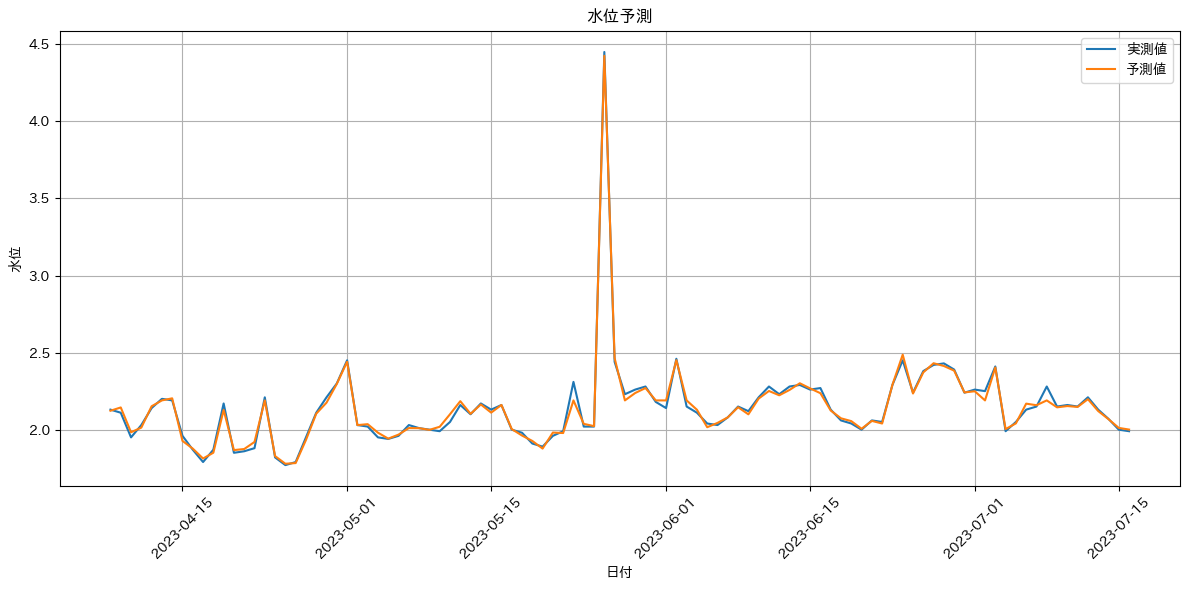

In [ ]:
# 部分拡大
show0(model0, 250,350)

In [ ]:
# 各データセットのサンプル数を決定
# train : val : test = 50% : 50% : 0%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.5)
n_test = len(dataset) - n_train - n_val

# サンプル数の確認
n_train, n_val ,n_test
# --
# (432, 432, 0)   2024/12/18現在

(432, 432, 0)

In [ ]:
# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
# test_loader = torch.utils.data.DataLoader(test, batch_size)

# 辞書型変数にまとめる(trainとvalをまとめて出す)
dataloaders_dict = {"train": train_loader, "val": val_loader}

In [ ]:
def train_model1(net, dataloaders_dict, lossfun, optimizer, num_epoch, savefile = 'best_model1.pth'):

    # GPUが使えるのであればGPUを有効化する
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = net.to(device)

    # (エポック)回分のループ
    for epoch in range(num_epoch):


        for phase in list(dataloaders_dict.keys()):

            if phase == 'train':
                # 学習モード
                net.train()
            else:
                # 推論モード
                net.eval()

            epoch_loss = 0.0

            # DataLoaderからデータを読み込む
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = torch.reshape(labels,(-1,1)) #サイズ変更
                # 勾配を初期化する
                optimizer.zero_grad()

                # 学習モードの場合のみ勾配の計算を可能にする
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    # 損失関数を使って損失を計算する
                    loss = lossfun(outputs, labels)

                    if phase == 'train':
                        # 誤差を逆伝搬する
                        loss.backward()
                        # パラメータを更新する
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)

            # 1エポックでの損失を計算
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)

        #epoch数とlossを表示する
        print(f'Epoch {epoch + 1}/{num_epoch}  epoch_loss:{epoch_loss:.4f}')
        print('-'*20)

        #モデルを保存
        torch.save(net, savefile)

    return net

#学習と検証
num_epoch = 30

# インスタンス化
model1 = Net0()

# 損失関数の設定(最小二乗誤差)
criterion1 = nn.MSELoss()

# 最適化手法の選択
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)

# 学習の実行
num_epoch = 100
model1 = train_model1(model1, dataloaders_dict, criterion1, optimizer1, num_epoch)

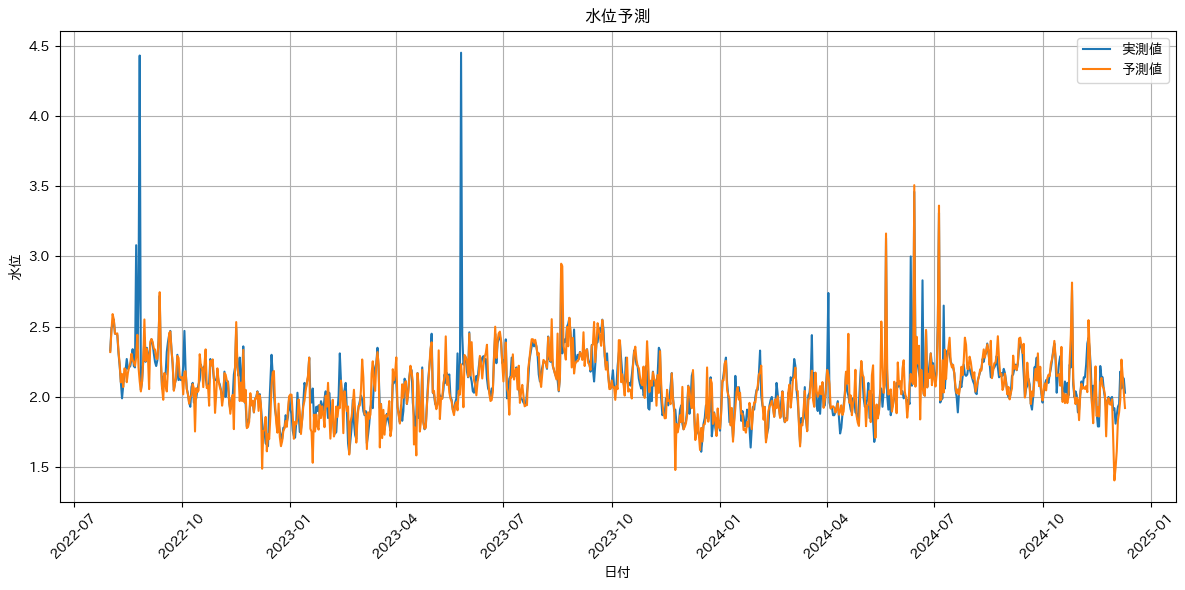

In [ ]:
show0(model1,0,-1)

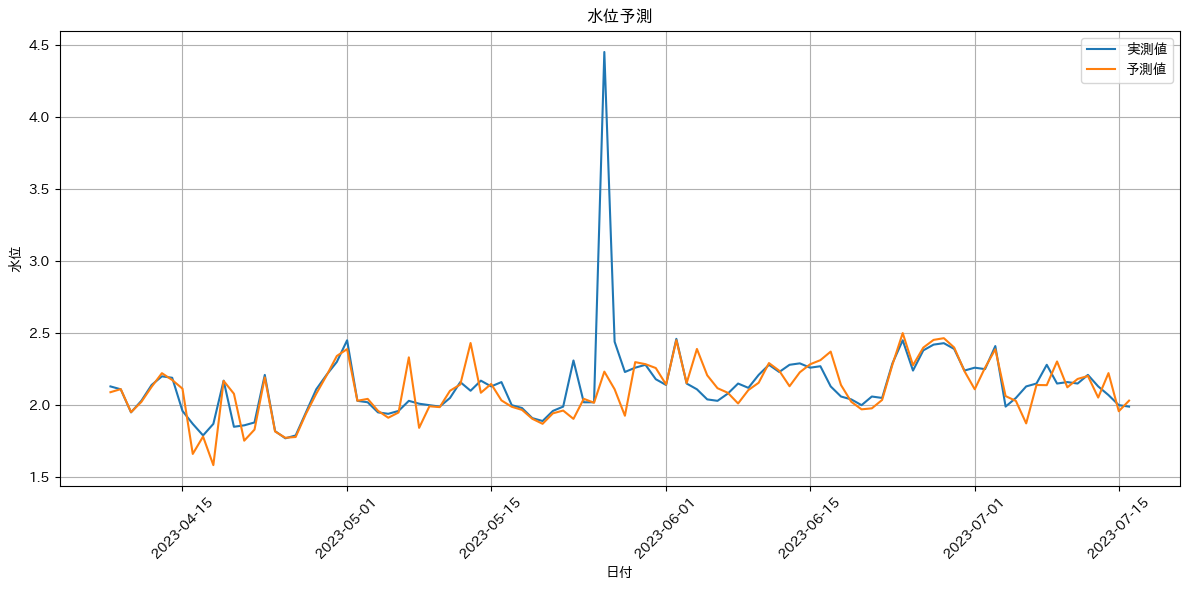

In [ ]:
show0(model1,250,350)

# LSTM Model(Long-Short Term Memory Model)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# ハイパーパラメータ設定
input_size = sdataXwithSuii.shape[1]
sequence_length = 7
hidden_size = 50
output_size = 1
num_layers = 2
num_epoch = 100
learning_rate = 0.01

# LSTMモデルの定義
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# データの読み込みと準備
data = sdataXwithSuii # 標準化後のアメダス＋水位データ

X = []
y = []
for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length]) # 取り出し位置を１つずつずらしながらシーケンス長分のベクトルをXにパッキング
    y.append([data[sequence_length+i,-1]]) # 水位データ（一番右にあるデータ）のみを出力として取り出してyにパッキング

X_train = torch.tensor(np.array(X), dtype=torch.float32) # テンソル化
y_train = torch.tensor(np.array(y), dtype=torch.float32) # テンソル化

# 入力変数と目的変数をまとめて、ひとつのオブジェクト dataset に変換
datasetLSTM = torch.utils.data.TensorDataset(X_train, y_train)

# 各データセットのサンプル数を決定
# train : val : test = 50% : 50% : 0%
n_train = int(len(datasetLSTM) * 0.5)
n_val = int(len(datasetLSTM) * 0.5)
n_test = len(datasetLSTM) - n_train - n_val

batch_size = 32

# データセットの分割
lstm_allloader = torch.utils.data.DataLoader(datasetLSTM, batch_size, shuffle=True)
lstm_train, lstm_val, lstm_test = torch.utils.data.random_split(datasetLSTM, [n_train, n_val, n_test])
lstm_train_loader = torch.utils.data.DataLoader(lstm_train, batch_size, shuffle=True)
lstm_val_loader = torch.utils.data.DataLoader(lstm_val, batch_size)
# lstm_test_loader = torch.utils.data.DataLoader(lstm_test, batch_size)

# 辞書型変数にまとめる(trainとvalをまとめて出す)
lstm_dataloaders_dict_all = {"train": lstm_allloader }
lstm_dataloaders_dict = {"train": lstm_train_loader, "val": lstm_val_loader}

In [ ]:
# LSTM用の学習プログラム
def lstm_train(net, dataloaders_dict, lossfun, optimizer, num_epoch):

    # (エポック)回分のループ
    for epoch in range(num_epoch):

        # GPUが使えるのであればGPUを有効化する
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        net = net.to(device)

        for phase in list(dataloaders_dict.keys()):
            print(phase)
            if phase == 'train':
                # 学習モード
                net.train()
            else:
                # 推論モード
                net.eval()

            epoch_loss = 0.0

            # DataLoaderからデータを読み込む
            for inputs, labels in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = torch.reshape(labels,(-1,1)) #サイズ変更
                # 勾配を初期化する
                optimizer.zero_grad()

                # 学習モードの場合のみ勾配の計算を可能にする
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    # 損失関数を使って損失を計算する
                    loss = lossfun(outputs, labels)

                    if phase == 'train':
                        # 誤差を逆伝搬する
                        loss.backward()
                        # パラメータを更新する
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)

            # 1エポックでの損失を計算
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)

            #epoch数とlossを表示する
            print(f'Epoch {epoch + 1}/{num_epoch} epoch_loss:{epoch_loss:.4f}')
            print('-'*20)
    return net

In [ ]:
# モデルの初期化とトレーニング
lstm_model_all = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion2 = nn.MSELoss()
optimizer2 = torch.optim.Adam(lstm_model_all.parameters(), lr=learning_rate)

# 学習の実行
num_epoch = 100
lstm_model_all = lstm_train(lstm_model_all, lstm_dataloaders_dict_all, criterion2, optimizer2, num_epoch)

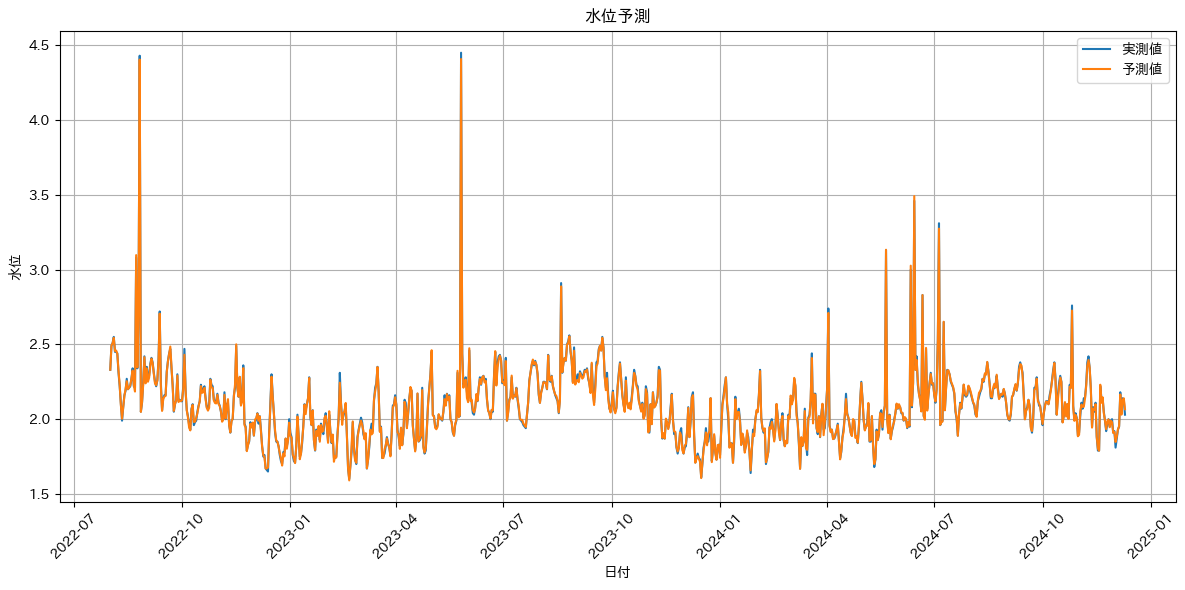

In [ ]:
# 上のプログラムで学習済みの net で全データの期間について水位予測し、実データと重ねてグラフを描く

def lstm_show(net, frm, to): #, loadfile='best_model.pth'):

    # Use the entire dataset for prediction
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()

    # 全期間にわたって、説明変数ｘから水位を予測→ y_pred
    with torch.no_grad():
      y_pred = net(X_train.to(device))

    predicted_water_levels = y_pred.cpu().numpy().flatten()
    predicted_water_levels = scalerY.inverse_transform(predicted_water_levels.reshape(-1, 1))
    actual_water_levels = t_tensor.cpu().numpy()
    actual_water_levels = scalerY.inverse_transform(actual_water_levels.reshape(-1, 1))

    # Create date range for the plot
    date_range = pd.date_range(start=merge_df['年月日'].min(), periods=len(actual_water_levels))

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(date_range[frm:to], actual_water_levels[frm:to], label='実測値')
    plt.plot(date_range[frm:to], predicted_water_levels[frm:to], label='予測値')

    plt.xlabel('日付')
    plt.ylabel('水位')
    plt.title('水位予測')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

lstm_show(net=lstm_model_all, frm=0,to=-1)

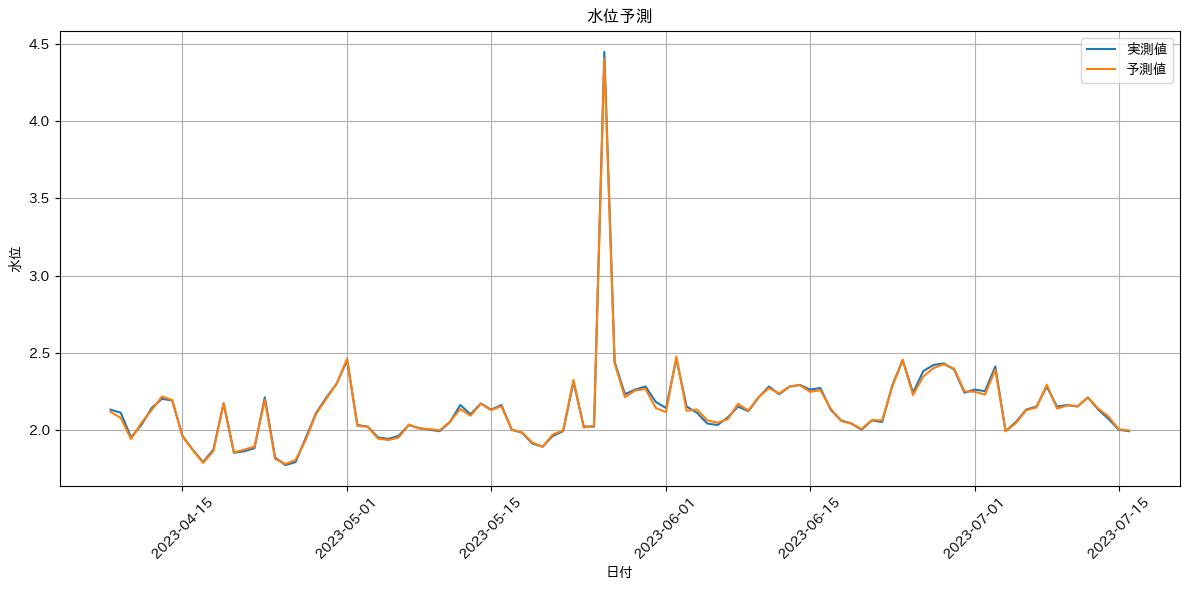

In [ ]:
# 部分拡大
lstm_show(net=lstm_model_all, frm=250,to=350)

In [ ]:
# モデルの初期化とトレーニング
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion3 = nn.MSELoss()
optimizer3 = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

# 学習の実行
num_epoch = 100
lstm_model = lstm_train(lstm_model, lstm_dataloaders_dict, criterion3, optimizer3, num_epoch)

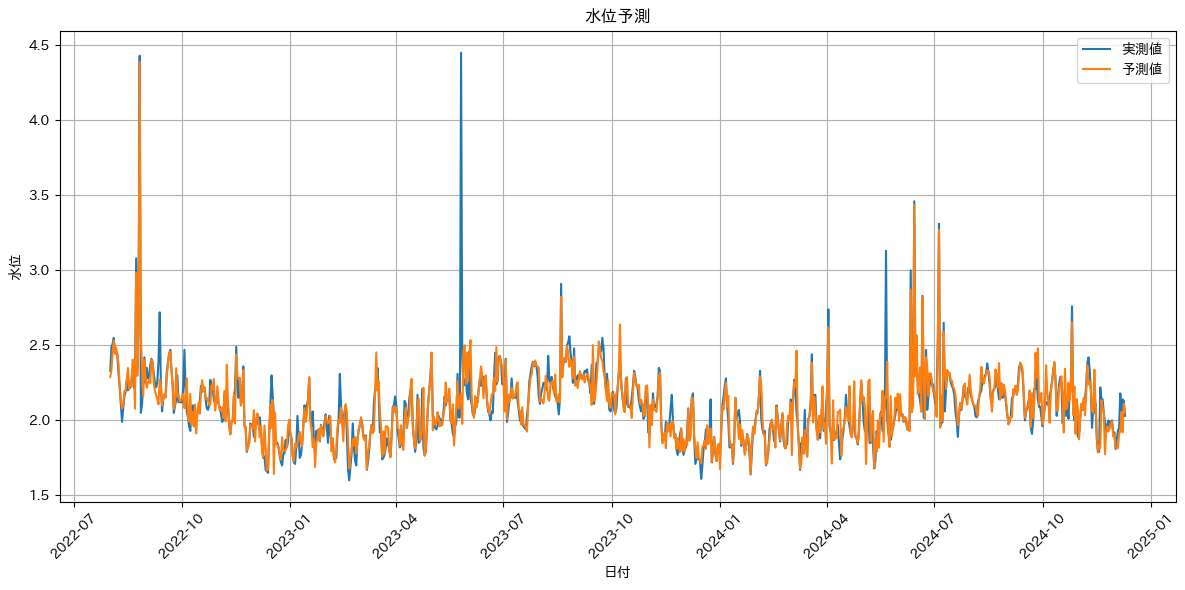

In [ ]:
lstm_show(net=lstm_model, frm=0,to=-1)

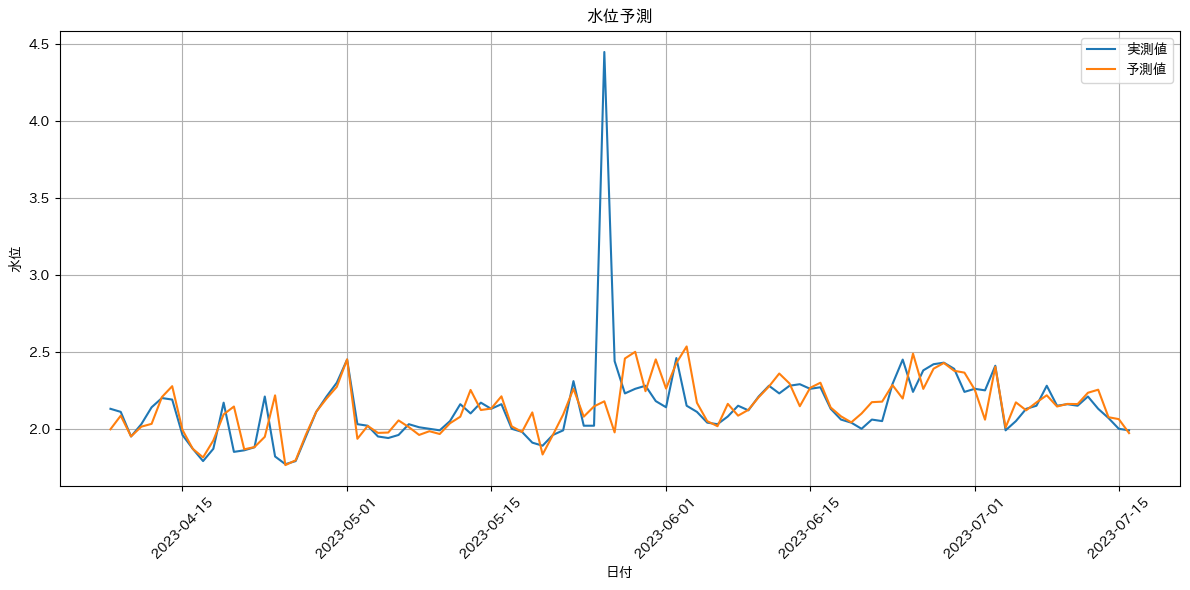

In [ ]:
lstm_show(net=lstm_model, frm=250,to=350)

# ３地点のアメダスデータを用いた水位予測

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# ７日間のアメダスデータを入力、次の日の水位データを出力して重回帰する 説明変数には水位が含まれないことに注意
span = 7
merge3_df = integrate(['堺','河内長野','大阪'],'戎橋')
numpy_data3 = merge3_df.to_numpy() # データフレームをnumpy arrayに変換
dataXwithSuii3 = numpy_data[:,1:] # 説明変数　すべて
dataY = numpy_data[:,-1].reshape(-1,1) # 目的変数 水位
scalerXwithSuii3 = StandardScaler() # 説明変数の標準化器の準備
scalerXwithSuii3.fit(dataXwithSuii3) # 説明変数の平均と分散を計算
scalerY = StandardScaler() # 目的変数の標準化の準備
scalerY.fit(dataY) # 目的変数の平均と分散を計算
sdataXwithSuii3 = scalerXwithSuii3.transform(dataXwithSuii3) # 説明変数を標準化
sdataY = scalerY.transform(dataY) # 目的変数を標準化

ydata = np.array(ydata).reshape(-1,1)
sdataXwithSuii3.shape, ydata.shape
# ーーーーー
# ((871, 6), (864, 1))　　2024年12月18日時点

((871, 6), (864, 1))

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# ハイパーパラメータ設定
input_size3 = sdataXwithSuii3.shape[1]
sequence_length = 7
hidden_size = 50
output_size = 1
num_layers = 2
num_epoch = 100
learning_rate = 0.01

# データの読み込みと準備
data = sdataXwithSuii3 # 標準化後のアメダス＋水位データ
X = []
y = []
for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length]) # 取り出し位置を１つずつずらしながらシーケンス長分のベクトルをXにパッキング
    y.append([data[sequence_length+i,-1]]) # 水位データ（一番右にあるデータ）のみを出力として取り出してyにパッキング

X_train3 = torch.tensor(np.array(X), dtype=torch.float32) # テンソル化
y_train = torch.tensor(np.array(y), dtype=torch.float32) # テンソル化

# 入力変数と目的変数をまとめて、ひとつのオブジェクト dataset に変換
datasetLSTM3 = torch.utils.data.TensorDataset(X_train3, y_train)

# 各データセットのサンプル数を決定
# train : val : test = 50% : 50% : 0%
n_train3 = int(len(datasetLSTM3) * 0.5)
n_val3 = int(len(datasetLSTM3) * 0.5)
n_test3 = len(datasetLSTM3) - n_train - n_val

batch_size = 32
# データセットの分割
lstm_allloader3 = torch.utils.data.DataLoader(datasetLSTM3, batch_size, shuffle=True)
lstm_train3, lstm_val3, lstm_test3 = torch.utils.data.random_split(datasetLSTM3, [n_train3, n_val3, n_test3])
lstm_train_loader3 = torch.utils.data.DataLoader(lstm_train3, batch_size, shuffle=True)
lstm_val_loader3 = torch.utils.data.DataLoader(lstm_val3, batch_size)
# lstm_test_loader3 = torch.utils.data.DataLoader(lstm_test3, batch_size)
# 辞書型変数にまとめる(trainとvalをまとめて出す)
lstm_dataloaders_dict_all3 = {"train": lstm_allloader3 }
lstm_dataloaders_dict3 = {"train": lstm_train_loader3, "val": lstm_val_loader}

In [ ]:
# モデルの初期化とトレーニング
lstm_model_all3 = LSTMModel(input_size3, hidden_size, output_size, num_layers)
criterion3 = nn.MSELoss()
optimizer3 = torch.optim.Adam(lstm_model_all3.parameters(), lr=learning_rate)
# 学習の実行
num_epoch = 100
lstm_model_all3 = lstm_train(lstm_model_all3, lstm_dataloaders_dict_all3, criterion3, optimizer3, num_epoch)

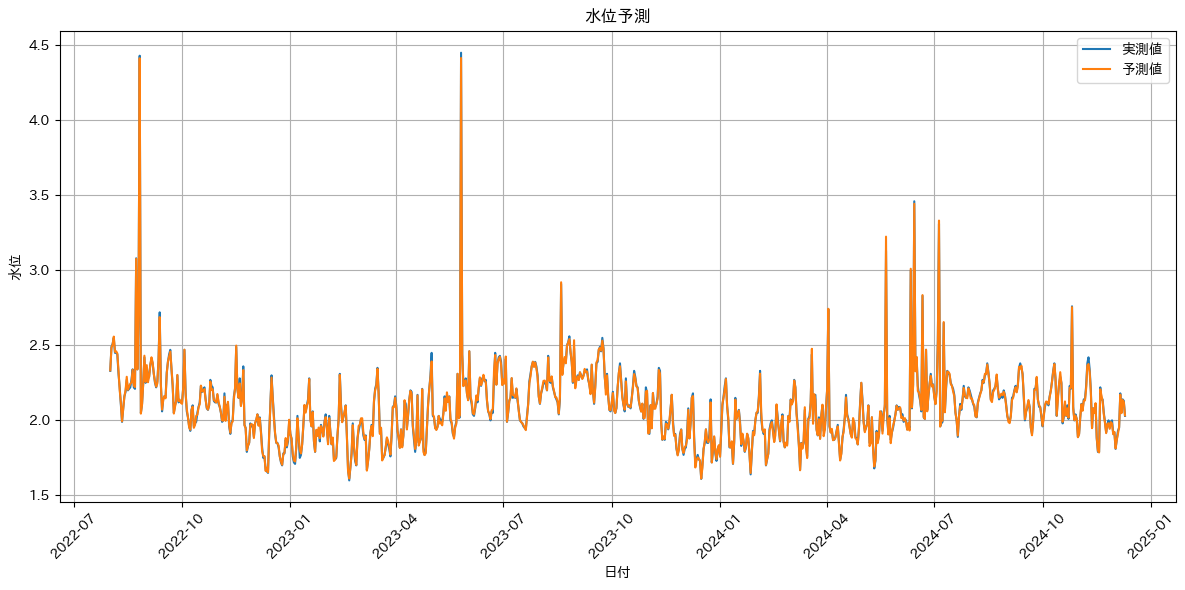

In [ ]:
lstm_show(net=lstm_model_all3, frm=0,to=-1)

In [ ]:
# モデルの初期化とトレーニング
lstm_model3 = LSTMModel(input_size3, hidden_size, output_size, num_layers)
criterion3 = nn.MSELoss()
optimizer3 = torch.optim.Adam(lstm_model3.parameters(), lr=learning_rate)

# 学習の実行
num_epoch = 100
lstm_model3 = lstm_train(lstm_model3, lstm_dataloaders_dict3, criterion3, optimizer3, num_epoch)

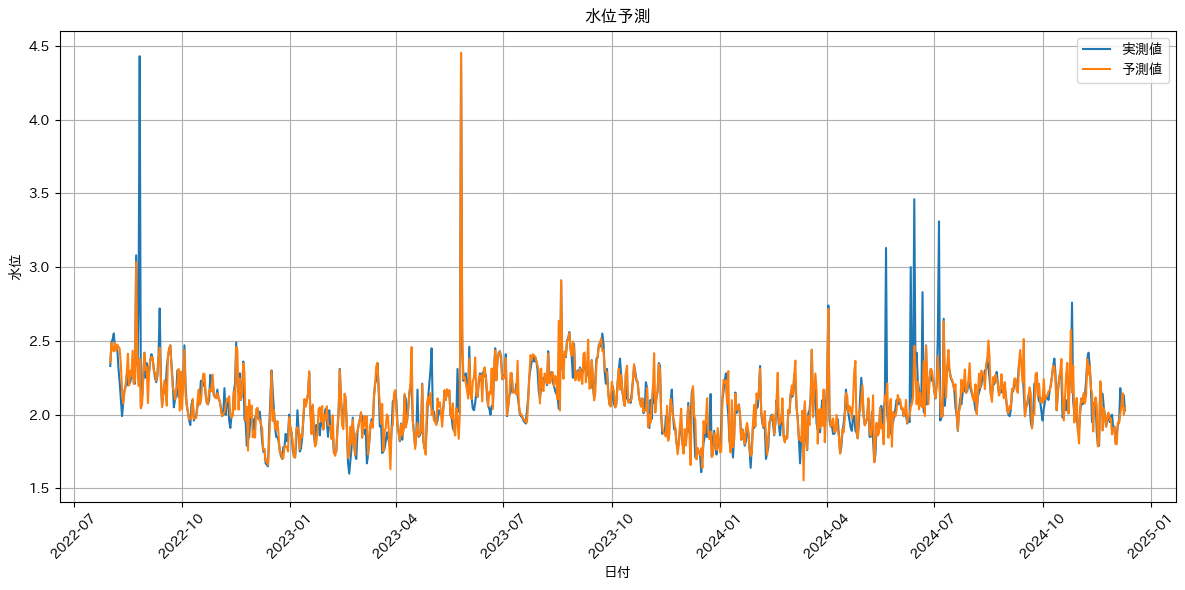

In [ ]:
lstm_show(net=lstm_model3, frm=0,to=-1)

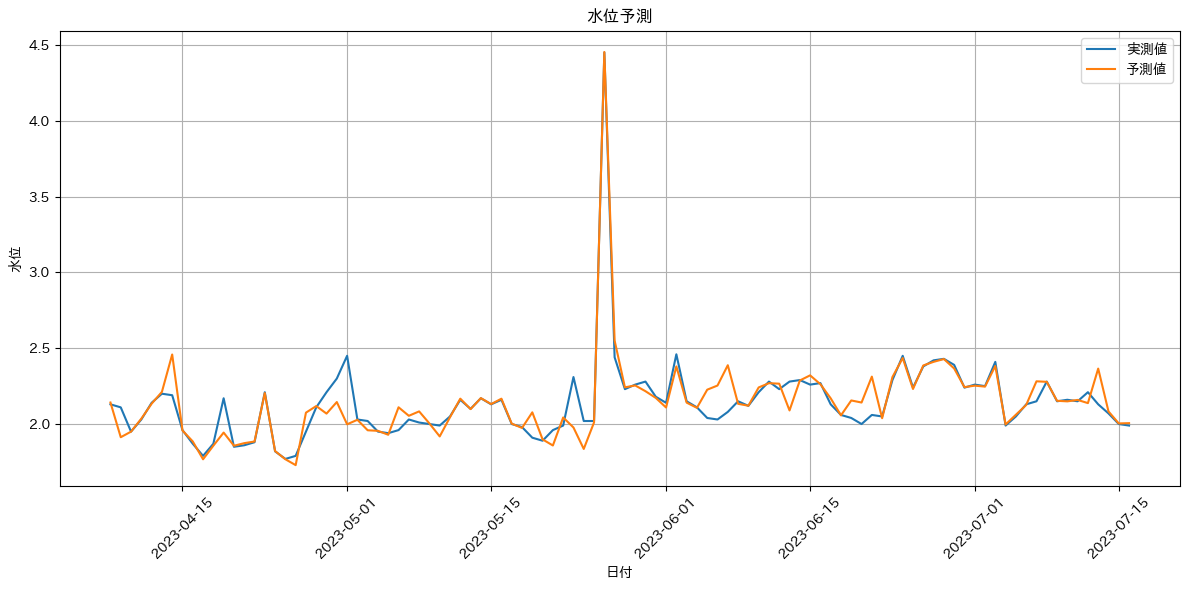

In [ ]:
lstm_show(net=lstm_model3, frm=250,to=350)

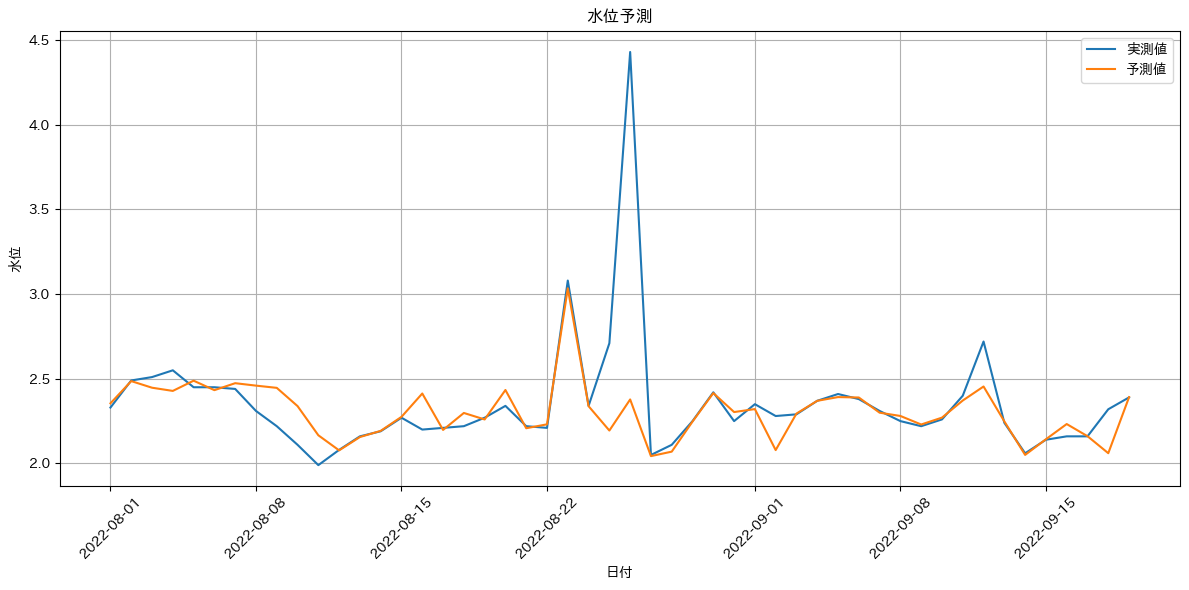

In [ ]:
lstm_show(net=lstm_model3, frm=0,to=50)